# zadanie 4
Porównanie wpływu działania poszczególnych tagerów jako narzędzi wstępnego przetwarzania na wyniki klasyfikacji tekstów (korpus Wikipedii zCLARN-PL) za pomocą naiwnego algorytmu Bayesowskiego

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
work_dir = '/content/drive/My Drive/DANsem2/NLP/p1/dane/'
test_data_pth = work_dir + 'test-rat.txt.zip'

In [13]:
import json
import requests
import xml.etree.ElementTree as ET
import time

from tqdm.notebook import tqdm
import os
import pandas as pd

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import sklearn.metrics
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import sklearn.ensemble

import seaborn as sns

In [4]:
gram_mapper = {
'subst':  'rzecz',
'depr':   'rzecz',
'num':    'rzecz',
'numcol': 'rzecz',
'adj':    'przym',
'adja':   'przym',
'adjp':   'przym',
'adjc':   'przym',
'adv':    'przys',
'ppron12':'rzecz',
'ppron3': 'rzecz',
'siebie': 'rzecz',
'fin':    'czas',
'bedzie': 'czas',
'aglt':   'czas',
'praet':  'czas',
'impt':   'czas',
'imps':   'czas',
'inf':    'czas',
'pcon':   'czas',
'pant':   'czas',
'ger':    'czas',
'pact':   'czas',
'ppas':   'czas',
'winien': '?',
'pred':   '?',
'prep':   '?',
'conj':   '?',
'comp':   '?',
'qub':    '?',
'brev':   '?',
'burk':   '?',
'interj': '?',
'interp': '?',
'xxx':    '?',
'ign':    '?',
}
def ccl_bases(ccl):
    tree = ET.fromstring(ccl)
    return [tok.find('./lex/base').text for tok in tree.iter('tok')]
def ccl_poses(ccl):
    tree = ET.fromstring(ccl)
    return [tok.find('./lex/ctag').text.split(":")[0] for tok in tree.iter('tok')]
def ccl_ctags(ccl):
    tree = ET.fromstring(ccl)
    return [tok.find('./lex/ctag').text for tok in tree.iter('tok')]
def ccl_orths(ccl):
    tree = ET.fromstring(ccl)
    return [tok.find('./orth').text.split(":")[0] for tok in tree.iter('tok')]
def ccl_simple_grammar(ccl):
    tags = ccl_poses(ccl)
    return [gram_mapper[w] for w in tags]

tagowanie danych z Wikipedii z pomocą usług sieciowych:

In [5]:
# snippet for KRNNT processing:
# wiki_test_dir = "wiki_test/"
# save_test_dir = "wiki_test_results/"
# for fileName in tqdm(os.listdir(wiki_test_dir)):
#     with open(wiki_test_dir+fileName, "r") as file:
#         text = file.read()
#     krnnt_url = 'https://krnnt-f3esrhez2q-ew.a.run.app/?output_format=conll'
#     #krnnt_url = 'localhost:9003/?output_format=conll'
#     r = requests.post(krnnt_url, 
#                     data=text.encode('utf-8'),
#                     headers={'Content-type': 'text/plain; charset=utf-8', "Accept-Language": "pl"})
#     ccl = r.content.decode('utf-8')
#     with open(save_test_dir+fileName[:-4]+".tsv", "w") as file:
#         file.write(ccl)

# wcrft / morphodita processing copied from previous task

przetworzenie otagowanych danych:

In [6]:
# preocess:
# import zipfile

# dataframes_test = {'KRNNT':[],'wcrft2':[],'MorphoDiTa':[]}
# dataframes_train = {'KRNNT':[],'wcrft2':[],'MorphoDiTa':[]}

# with zipfile.ZipFile(work_dir+'wiki_test_krnnt_results.zip', 'r') as archive:
#     filenames = archive.namelist()
#     print(len(filenames))
#     for filename in filenames:
#         #file_content = archive.read(filename)
#         file_ = archive.open(filename)
#         df_tmp = pd.read_csv(file_, names=["orth","base","sep","ctag","start","end"],
#                              sep='\t')
#         df_tmp['target'] = filename.split('_')[0]
#         df_tmp['filename'] = filename
#         df_tmp['tager'] = 'KRNNT'
#         df_tmp['parts_of_speech'] = df_tmp['ctag'].apply(lambda x: gram_mapper.setdefault(x.split(':')[0], '?'))
#         dataframes_test['KRNNT'].append(df_tmp)

# with zipfile.ZipFile(work_dir+'wiki_test_34_categories_results_wcrft2.zip', 'r') as archive:
#     filenames = archive.namelist()
#     print(len(filenames))
#     for filename in filenames:
#         ccl = archive.read(filename)
#         #file_ = archive.open(filename)
#         df_tmp = pd.DataFrame({'base':ccl_bases(ccl),'orth':ccl_orths(ccl),'ctag':ccl_ctags(ccl)})
#         #df_tmp = pdx.read_xml(file_content, ["orth","base","ctag"])
#         df_tmp['target'] = filename.split('_')[0]
#         df_tmp['filename'] = filename
#         df_tmp['tager'] = 'wcrft2'
#         df_tmp['parts_of_speech'] = df_tmp['ctag'].apply(lambda x: gram_mapper.setdefault(x.split(':')[0], '?'))
#         dataframes_test['wcrft2'].append(df_tmp)

# with zipfile.ZipFile(work_dir+'wiki_test_34_categories_results_morphodita.zip', 'r') as archive:
#     filenames = archive.namelist()
#     print(len(filenames))
#     for filename in filenames:
#         ccl = archive.read(filename)
#         #file_ = archive.open(filename)
#         df_tmp = pd.DataFrame({'base':ccl_bases(ccl),'orth':ccl_orths(ccl),'ctag':ccl_ctags(ccl)})
#         #df_tmp = pdx.read_xml(file_content, ["orth","base","ctag"])
#         df_tmp['target'] = filename.split('_')[0]
#         df_tmp['filename'] = filename
#         df_tmp['tager'] = 'MorphoDiTa'
#         df_tmp['parts_of_speech'] = df_tmp['ctag'].apply(lambda x: gram_mapper.setdefault(x.split(':')[0], '?'))
#         dataframes_test['MorphoDiTa'].append(df_tmp)


# with zipfile.ZipFile(work_dir+'wiki_train_krnnt_results.zip', 'r') as archive:
#     filenames = archive.namelist()
#     print(len(filenames))
#     for filename in filenames:
#         #file_content = archive.read(filename)
#         file_ = archive.open(filename)
#         df_tmp = pd.read_csv(file_, names=["orth","base","sep","ctag","start","end"],
#                              sep='\t')
#         df_tmp['target'] = filename.split('_')[0]
#         df_tmp['filename'] = filename
#         df_tmp['tager'] = 'KRNNT'
#         df_tmp['parts_of_speech'] = df_tmp['ctag'].apply(lambda x: gram_mapper.setdefault(x.split(':')[0], '?'))
#         dataframes_train['KRNNT'].append(df_tmp)

# with zipfile.ZipFile(work_dir+'wiki_train_34_categories_results_wcrft2.zip', 'r') as archive:
#     filenames = archive.namelist()
#     print(len(filenames))
#     for filename in filenames:
#         ccl = archive.read(filename)
#         #file_ = archive.open(filename)
#         df_tmp = pd.DataFrame({'base':ccl_bases(ccl),'orth':ccl_orths(ccl),'ctag':ccl_ctags(ccl)})
#         #df_tmp = pdx.read_xml(file_content, ["orth","base","ctag"])
#         df_tmp['target'] = filename.split('_')[0]
#         df_tmp['filename'] = filename
#         df_tmp['tager'] = 'wcrft2'
#         df_tmp['parts_of_speech'] = df_tmp['ctag'].apply(lambda x: gram_mapper.setdefault(x.split(':')[0], '?'))
#         dataframes_train['wcrft2'].append(df_tmp)

# with zipfile.ZipFile(work_dir+'wiki_train_34_categories_results_morphodita.zip', 'r') as archive:
#     filenames = archive.namelist()
#     print(len(filenames))
#     for filename in filenames:
#         ccl = archive.read(filename)
#         #file_ = archive.open(filename)
#         df_tmp = pd.DataFrame({'base':ccl_bases(ccl),'orth':ccl_orths(ccl),'ctag':ccl_ctags(ccl)})
#         #df_tmp = pdx.read_xml(file_content, ["orth","base","ctag"])
#         df_tmp['target'] = filename.split('_')[0]
#         df_tmp['filename'] = filename
#         df_tmp['tager'] = 'MorphoDiTa'
#         df_tmp['parts_of_speech'] = df_tmp['ctag'].apply(lambda x: gram_mapper.setdefault(x.split(':')[0], '?'))
#         dataframes_train['MorphoDiTa'].append(df_tmp)

In [7]:
# if the backup is already present:
import pickle

# with open(work_dir+'dataframes_test.pickle', 'wb') as handle:
#     pickle.dump(dataframes_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(work_dir+'dataframes_train.pickle', 'wb') as handle:
#     pickle.dump(dataframes_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(work_dir+'dataframes_test.pickle', 'rb') as handle:
    dataframes_test = pickle.load(handle)

with open(work_dir+'dataframes_train.pickle', 'rb') as handle:
    dataframes_train = pickle.load(handle)

grid search po przestrzeni hiperparametrów:

In [8]:
def corpus_n_target_from_dataframe_list(dataframe_list):
    corpus = {'KRNNT':[], 'wcrft2':[], 'MorphoDiTa':[]}
    target = {'KRNNT':[], 'wcrft2':[], 'MorphoDiTa':[]}
    for tager, dfs_tmp in dataframe_list.items():
        for x in dfs_tmp:
            if len(x)==0:
                continue
            corpus[tager].append(' '.join(x[x.parts_of_speech==part_of_speech].base.astype('str').tolist()))
            target[tager].append(x.target[0]) # label
    return corpus, target

In [17]:
all_results=[]

for part_of_speech in tqdm(['przym','rzecz','czas',], leave=True):
    corpus_train, target_train = corpus_n_target_from_dataframe_list(dataframes_train)
    corpus_test, target_test = corpus_n_target_from_dataframe_list(dataframes_test)

    for vocab_size in tqdm([100, 200, 300, 400, 500, 750, 1000], leave=True):
        for tager in tqdm(['KRNNT', 'wcrft2', 'MorphoDiTa']):
            text_clf = Pipeline([
                ('vect', CountVectorizer(max_features=vocab_size)),
                ('clf', MultinomialNB()),
            ])
            text_clf.fit(corpus_train[tager], target_train[tager])
            results = text_clf.predict(corpus_test[tager])
            all_results.append({
                'tager': tager,
                'vocab_size': vocab_size,
                'part_of_speech': part_of_speech,
                'accuracy': sklearn.metrics.accuracy_score(target_test[tager], results),
                'f1_score': sklearn.metrics.f1_score(target_test[tager], results, average='macro'),
                'Model': 'MultinomialNB',
            })
            ensemble_clf = Pipeline([
                ('vect', CountVectorizer(max_features=vocab_size)),
                ('clf', sklearn.ensemble.BaggingClassifier(MultinomialNB())),
            ])
            #extras - ensemble
            ensemble_clf.fit(corpus_train[tager], target_train[tager])
            results = ensemble_clf.predict(corpus_test[tager])
            all_results.append({
                'tager': tager,
                'vocab_size': vocab_size,
                'part_of_speech': part_of_speech,
                'accuracy': sklearn.metrics.accuracy_score(target_test[tager], results),
                'f1_score': sklearn.metrics.f1_score(target_test[tager], results, average='macro'),
                'Model': 'ensemble of MultinomialNB',
            })

results_df = pd.DataFrame(all_results)

,tager,vocab_size,part_of_speech,Model,metric_type,metric
0,KRNNT,100,przym,MultinomialNB,accuracy,0.393631
1,KRNNT,100,przym,ensemble of MultinomialNB,accuracy,0.392276
2,wcrft2,100,przym,MultinomialNB,accuracy,0.463076
3,wcrft2,100,przym,ensemble of MultinomialNB,accuracy,0.470190
4,MorphoDiTa,100,przym,MultinomialNB,accuracy,0.390244


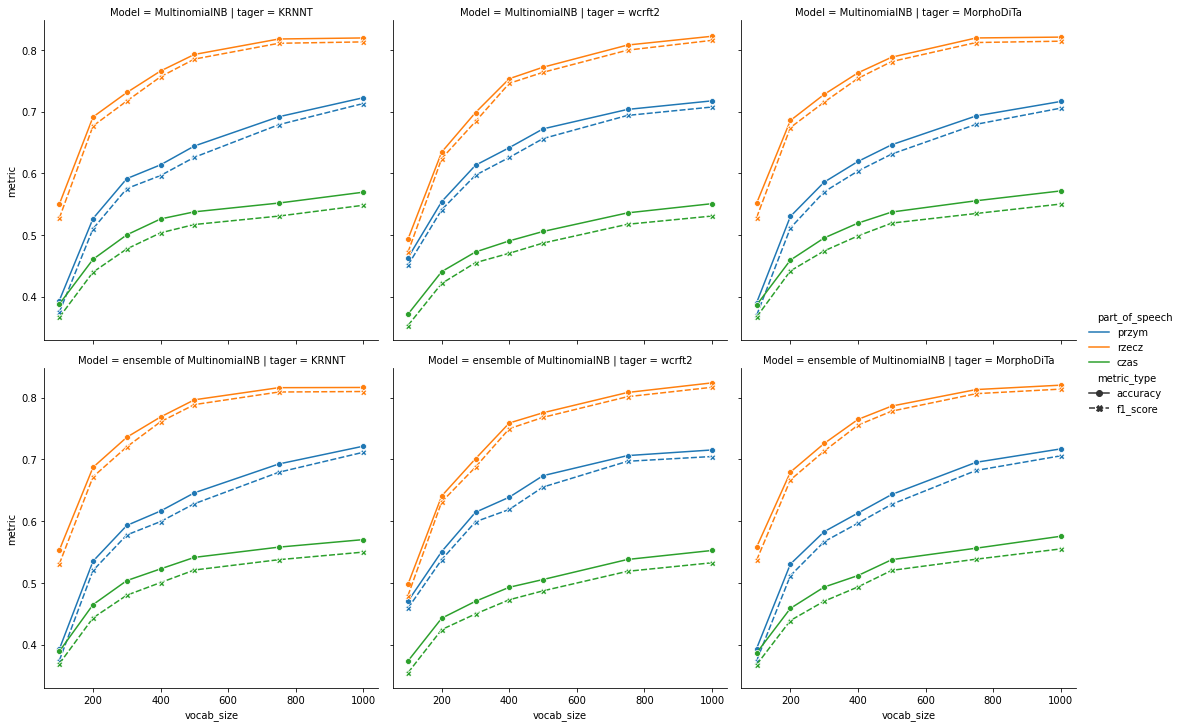

In [18]:
plot_df = pd.melt(results_df, id_vars=['tager','vocab_size','part_of_speech', 'Model'], value_vars=['accuracy','f1_score'],
                  var_name='metric_type', value_name='metric')
sns.relplot(kind='line',data=plot_df, markers=True,
            x='vocab_size', y='metric', style='metric_type', col='tager', row='Model', hue='part_of_speech')
plot_df.head()

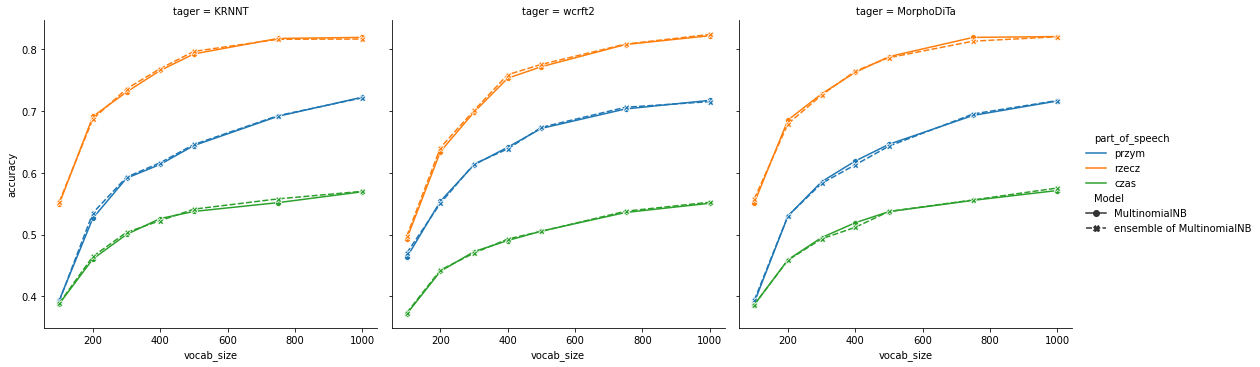

In [19]:
sns.relplot(kind='line',data=results_df, markers=True,
            x='vocab_size', y='accuracy', style='Model', col='tager', hue='part_of_speech')

no significant improovement was noticed when using bootstrap aggregated MultinomialNB's